# Srilanka Dengue Outbreak Forecasting using Darts

## Environment Setup

In [1]:
!pip install darts
!pip install dask[dataframe]
!pip install statsmodels

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 54.7/54.7 kB 2.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 169.6/169.6 kB 4.5 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 963.3/963.3 kB 21.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.1/2.1 MB 46.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 819.3/819.3 kB 30.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.3/13.3 MB 27.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 319.1/319.1 kB 14.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.0/44.0 kB 3.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 101.7/101.7 kB 8.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 275.6/275.6 kB 18.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 278.2/278.2 kB 16.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 927.3/927.3 kB 38.2 MB/s eta 0:00:

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


## 1. Imports

In [3]:
import os
import pickle
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

from darts import TimeSeries

%matplotlib inline

## 2. Load Dataset

In [4]:
df = pd.read_csv("/content/drive/MyDrive/Datasets/Sri_Lanka_Dengue_Cases_and_Weather_Data_updated.csv")

In [5]:
df.head()

,District,Number_of_Cases,Week_Start_Date,Year,Month,Week,Week_End_Date,Avg Max Temp (°C),Avg Min Temp (°C),Avg Apparent Max Temp (°C),Avg Apparent Min Temp (°C),Total Precipitation (mm),Avg Wind Speed (km/h),Max Wind Gusts (km/h),Avg Daylight Duration (hours)
0,Ampara,0,2007-01-01,2007,1,1,2007-01-08,26.9375,21.8625,28.8500,24.1000,8.0,18.2000,44.3,11.714583
1,Ampara,0,2007-01-08,2007,1,2,2007-01-15,26.3500,23.3250,30.2625,26.7000,86.1,17.0250,43.6,11.733333
2,Ampara,0,2007-01-15,2007,1,3,2007-01-22,27.2125,23.1625,29.5750,25.9625,3.1,20.1875,48.2,11.754167
3,Ampara,0,2007-01-22,2007,1,4,2007-01-29,26.7250,23.0375,29.9500,26.1125,53.6,17.2000,42.5,11.783333
4,Ampara,0,2007-01-29,2007,1,5,2007-02-05,27.3625,22.9625,30.7500,26.1250,8.2,17.2625,40.0,11.812500


In [6]:
len(df)

23250

In [7]:
districts = df['District'].unique()
districts

array(['Ampara', 'Anuradhapura', 'Badulla', 'Batticaloa', 'Colombo',
       'Galle', 'Gampaha', 'Hambantota', 'Jaffna', 'Kalutara', 'Kandy',
       'Kegalle', 'Kilinochchi', 'Kurunegala', 'Mannar', 'Matale',
       'Matara', 'Monaragala', 'Mullaitivu', 'NuwaraEliya', 'Polonnaruwa',
       'Puttalam', 'Ratnapura', 'Trincomalee', 'Vavuniya'], dtype=object)

## 3. Small Visualization

In [8]:
# Check Duplicate values
duplicates = df[['District', 'Week_Start_Date', 'Week_End_Date']].duplicated().any()
if duplicates:
    print("There are duplicate values.")
else:
    print("No duplicates found.")

No duplicates found.


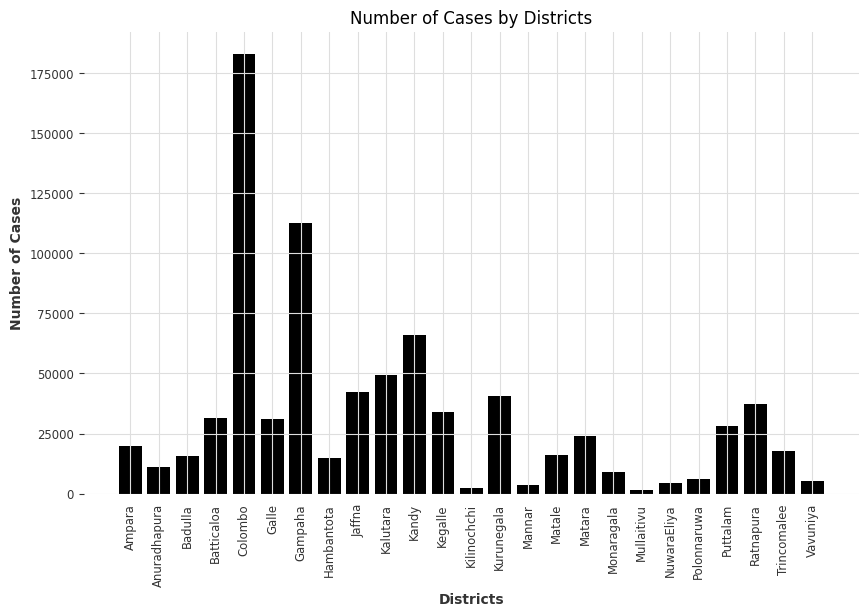

In [9]:
# Group by District and sum the Number of Cases
district_cases = df.groupby('District')['Number_of_Cases'].sum().reset_index()

# Plotting the histogram
plt.figure(figsize=(10, 6))
plt.bar(district_cases['District'], district_cases['Number_of_Cases'])
plt.xlabel('Districts')
plt.ylabel('Number of Cases')
plt.title('Number of Cases by Districts')
plt.xticks(rotation=90)
plt.show()


## 4. Minor pre-processing
1. Only taking single timestamp for each row. Either `Week_Start_Date` or `Week_Start_Date`. We gonna take `Week_End_Date`.
2. Convert the `Week_End_Date` to Python Datetime format.
3. Eliminate un-used features such as `Week_Start_Date`, `Month`, `Year`, and `Week`

In [10]:
df['Week_End_Date'] = pd.to_datetime(df['Week_End_Date'])

In [11]:
df.head()

,District,Number_of_Cases,Week_Start_Date,Year,Month,Week,Week_End_Date,Avg Max Temp (°C),Avg Min Temp (°C),Avg Apparent Max Temp (°C),Avg Apparent Min Temp (°C),Total Precipitation (mm),Avg Wind Speed (km/h),Max Wind Gusts (km/h),Avg Daylight Duration (hours)
0,Ampara,0,2007-01-01,2007,1,1,2007-01-08,26.9375,21.8625,28.8500,24.1000,8.0,18.2000,44.3,11.714583
1,Ampara,0,2007-01-08,2007,1,2,2007-01-15,26.3500,23.3250,30.2625,26.7000,86.1,17.0250,43.6,11.733333
2,Ampara,0,2007-01-15,2007,1,3,2007-01-22,27.2125,23.1625,29.5750,25.9625,3.1,20.1875,48.2,11.754167
3,Ampara,0,2007-01-22,2007,1,4,2007-01-29,26.7250,23.0375,29.9500,26.1125,53.6,17.2000,42.5,11.783333
4,Ampara,0,2007-01-29,2007,1,5,2007-02-05,27.3625,22.9625,30.7500,26.1250,8.2,17.2625,40.0,11.812500


## 5. Modelling
List of classical/statistical models.
- ARIMA
- AutoARIMA
- VARIMA
- ExponentialSmoothing
- FourTheta
- Prophet
- FFT
- KalmanForecaster

In [12]:
from darts.models import ARIMA, AutoARIMA, VARIMA, ExponentialSmoothing, FourTheta, Prophet, FFT, KalmanForecaster
from darts.metrics import rmse, mae, smape, rmsle

In [13]:
models = [ARIMA(p=12, d=1, q=0), AutoARIMA(), ExponentialSmoothing(), Prophet(), FFT(), KalmanForecaster()]

In [14]:
def train_and_forecast(train_series, val_series, future_covariates, model, district_name):
    if future_covariates:
      model.fit(train_series, future_covariates=future_covariates)
    else:
      model.fit(train_series)

    # Forecast for the next 12 weeks
    forecast=None
    if future_covariates:
      forecast = model.predict(n=len(val_series), future_covariates=future_covariates)
    else:
      forecast = model.predict(n=len(val_series))

    # Calculate metrics
    val_values = val_series.values()
    forecast_values = forecast.values()

    # Ensure the forecast and validation values are the same length
    assert len(val_values) == len(forecast_values), "Forecast and validation series must have the same length for metrics calculation."

    # Compute metrics
    error_rmse = rmse(val_series, forecast)
    error_mae = mae(val_series, forecast)
    error_smape = smape(val_series, forecast)
    error_rmsle = rmsle(val_series, forecast)

    errors = {
        "RMSE": error_rmse,
        "MAE": error_mae,
        "SMAPE": error_smape,
        "RMSLE": error_rmsle
    }
    results = [forecast, errors]
    return results

In [17]:
def main(data, models):
    districts = data['District'].unique()
    final_output = []
    for district in districts:
      # Filter data for the specified district
      district_data = data[data['District'] == district]

      # Ensure the 'Week_End_Date' column is in datetime format
      district_data['Week_End_Date'] = pd.to_datetime(district_data['Week_End_Date'])

      # Prepare the data for ARIMA
      series = TimeSeries.from_dataframe(district_data, time_col='Week_End_Date', value_cols=['Number_of_Cases', 'Avg Max Temp (°C)', "Avg Min Temp (°C)", "Avg Apparent Max Temp (°C)", "Avg Apparent Min Temp (°C)", "Total Precipitation (mm)", "Avg Daylight Duration (hours)", "Avg Wind Speed (km/h)"])

      # Split series
      # Set aside the last 12 weeks as a validation series
      train_data, val_data = series["Number_of_Cases"][:-12], series["Number_of_Cases"][-12:]
      future_covariates = series[["Avg Max Temp (°C)", "Avg Min Temp (°C)", "Avg Apparent Max Temp (°C)", "Avg Apparent Min Temp (°C)", "Total Precipitation (mm)", "Avg Daylight Duration (hours)", "Avg Wind Speed (km/h)"]]

      print(f"Training length: {len(train_data)}")
      print(f"Validation length: {len(val_data)}")

      district_output = []
      for index, m in enumerate(models):
        if index >= 2:
          future_covariates = None
        result = train_and_forecast(train_data, val_data, future_covariates, m, district)
        district_output.append(result)

      final_output.append(district_output)

    return final_output


In [18]:
results = main(df, models)

<ipython-input-17-c3d2e98fe393>:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  district_data['Week_End_Date'] = pd.to_datetime(district_data['Week_End_Date'])


Training length: 918
Validation length: 12


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/usr/local/lib/python3.10/dist-packages/darts/metrics/metrics.py:1937: RuntimeWarning: invalid value encountered in log
  y_true, y_pred = np.log(y_true + 1), np.log(y_pred + 1)
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpnsa7ecwy/5jbqao1w.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpnsa7ecwy/jcn3hpj7.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=11333', 'data', 'file=/tmp/tmpnsa7ecwy/5jbqao1w.json', 'init=/tmp/tmpnsa

Training length: 918
Validation length: 12


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/usr/local/lib/python3.10/dist-packages/darts/metrics/metrics.py:1937: RuntimeWarning: invalid value encountered in log
  y_true, y_pred = np.log(y_true + 1), np.log(y_pred + 1)
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpnsa7ecwy/r45u_0gc.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpnsa7ecwy/b4hnpv7j.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=37977', 'data', 'file=/tmp/tmpnsa7ecwy/r45u_0gc.json', 'init=/tmp/tmpnsa

Training length: 918
Validation length: 12


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/usr/local/lib/python3.10/dist-packages/darts/metrics/metrics.py:1937: RuntimeWarning: invalid value encountered in log
  y_true, y_pred = np.log(y_true + 1), np.log(y_pred + 1)
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpnsa7ecwy/cn5mukcz.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpnsa7ecwy/ftc7fvnv.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=73786', 'data', 'file=/tmp/tmpnsa7ecwy/cn5mukcz.json', 'init=/tmp/tmpnsa

Training length: 918
Validation length: 12


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpnsa7ecwy/r2aqd4ob.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpnsa7ecwy/nlpqn9ue.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=38374', 'data', 'file=/tmp/tmpnsa7ecwy/r2aqd4ob.json', 'init=/tmp/tmpnsa7ecwy/nlpqn9ue.json', 'output', 'file=/tmp/tmpnsa7ecwy/prophet_model76a7w8we/prophet_model-20241230165014.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
16:50:14 - cmd

Training length: 918
Validation length: 12


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/holtwinters/model.py:918: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpnsa7ecwy/duv7bj6h.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpnsa7ecwy/d48j1hfi.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=32259', 'data', 'file=/tmp/tmpnsa7ecwy/duv7bj6h.json', 'init=/tmp/tmpnsa7ecwy/d48j1hfi.json', 'output', 'file=/tmp/tmpnsa7ecwy/prophet_modelxtspa5wg/prophet_model-20241230165100.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
16:51:00 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmd

Training length: 918
Validation length: 12


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/usr/local/lib/python3.10/dist-packages/darts/metrics/metrics.py:1937: RuntimeWarning: invalid value encountered in log
  y_true, y_pred = np.log(y_true + 1), np.log(y_pred + 1)
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpnsa7ecwy/wypjbklq.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpnsa7ecwy/tz6yss4w.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=41452', 'data', 'file=/tmp/tmpnsa7ecwy/wypjbklq.json', 'init=/tmp/tmpnsa

Training length: 918
Validation length: 12


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpnsa7ecwy/j91t3qg8.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpnsa7ecwy/885xpkvw.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=20501', 'data', 'file=/tmp/tmpnsa7ecwy/j91t3qg8.json', 'init=/tmp/tmpnsa7ecwy/885xpkvw.json', 'output', 'file=/tmp/tmpnsa7ecwy/prophet_modelnh7irg9s/prophet_model-20241230165426.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
16:54:26 - cmd

Training length: 918
Validation length: 12


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/usr/local/lib/python3.10/dist-packages/darts/metrics/metrics.py:1937: RuntimeWarning: invalid value encountered in log
  y_true, y_pred = np.log(y_true + 1), np.log(y_pred + 1)
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpnsa7ecwy/agdqw_0g.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpnsa7ecwy/7csd7rpl.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=91472', 'data', 'file=/tmp/tmpnsa7ecwy/agdqw_0g.json', 'init=/tmp/tmpnsa

Training length: 918
Validation length: 12


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/usr/local/lib/python3.10/dist-packages/darts/metrics/metrics.py:1937: RuntimeWarning: invalid value encountered in log
  y_true, y_pred = np.log(y_true + 1), np.log(y_pred + 1)
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpnsa7ecwy/2ub33o12.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpnsa7ecwy/g7pmbuvj.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=98575', 'data', 'file=/tmp/tmpnsa7ecwy/2ub33o12.json', 'init=/tmp/tmpnsa

Training length: 918
Validation length: 12


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpnsa7ecwy/ojvjo8f6.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpnsa7ecwy/3s70o2sr.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=58109', 'data', 'file=/tmp/tmpnsa7ecwy/ojvjo8f6.json', 'init=/tmp/tmpnsa7ecwy/3s70o2sr.json', 'output', 'file=/tmp/tmpnsa7ecwy/prophet_model9_t9hq08/prophet_model-20241230165921.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
16:59:21 - cmd

Training length: 918
Validation length: 12


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpnsa7ecwy/62veuuni.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpnsa7ecwy/t7602h0k.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=88986', 'data', 'file=/tmp/tmpnsa7ecwy/62veuuni.json', 'init=/tmp/tmpnsa7ecwy/t7602h0k.json', 'output', 'file=/tmp/tmpnsa7ecwy/prophet_model304wam51/prophet_model-20241230170056.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
17:00:56 - cmd

Training length: 918
Validation length: 12


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/usr/local/lib/python3.10/dist-packages/darts/metrics/metrics.py:1937: RuntimeWarning: invalid value encountered in log
  y_true, y_pred = np.log(y_true + 1), np.log(y_pred + 1)
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpnsa7ecwy/pxr4q6or.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpnsa7ecwy/_2azcr2p.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=96539', 'data', 'file=/tmp/tmpnsa7ecwy/pxr4q6or.json', 'init=/tmp/tmpnsa

Training length: 918
Validation length: 12


INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpnsa7ecwy/k02xvobt.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpnsa7ecwy/iw6618o7.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=97991', 'data', 'file=/tmp/tmpnsa7ecwy/k02xvobt.json', 'init=/tmp/tmpnsa7ecwy/iw6618o7.json', 'output', 'file=/tmp/tmpnsa7ecwy/prophet_modelw2h36395/prophet_model-20241230170435.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
17:04:35 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
17:04:35 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
<ipython-input-17-c3d2e98fe393>:9: Setti

Training length: 918
Validation length: 12


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpnsa7ecwy/0g3vl34f.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpnsa7ecwy/qm8z7wpl.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=31899', 'data', 'file=/tmp/tmpnsa7ecwy/0g3vl34f.json', 'init=/tmp/tmpnsa7ecwy/qm8z7wpl.json', 'output', 'file=/tmp/tmpnsa7ecwy/prophet_model7glxmb9p/prophet_model-20241230170629.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
17:06:29 - cmd

Training length: 918
Validation length: 12


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpnsa7ecwy/h5tt584w.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpnsa7ecwy/ohflds03.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=26730', 'data', 'file=/tmp/tmpnsa7ecwy/h5tt584w.json', 'init=/tmp/tmpnsa7ecwy/ohflds03.json', 'output', 'file=/tmp/tmpnsa7ecwy/prophet_modele00gqzeo/prophet_model-20241230170817.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
17:08:17 - cmd

Training length: 918
Validation length: 12


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/usr/local/lib/python3.10/dist-packages/darts/metrics/metrics.py:1937: RuntimeWarning: invalid value encountered in log
  y_true, y_pred = np.log(y_true + 1), np.log(y_pred + 1)
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpnsa7ecwy/r48r1ptw.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpnsa7ecwy/7s3mwaou.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=54064', 'data', 'file=/tmp/tmpnsa7ecwy/r48r1ptw.json', 'init=/tmp/tmpnsa

Training length: 918
Validation length: 12


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpnsa7ecwy/e715jdya.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpnsa7ecwy/ae697dgi.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=12237', 'data', 'file=/tmp/tmpnsa7ecwy/e715jdya.json', 'init=/tmp/tmpnsa7ecwy/ae697dgi.json', 'output', 'file=/tmp/tmpnsa7ecwy/prophet_modelplfe_w4d/prophet_model-20241230171122.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
17:11:22 - cmd

Training length: 918
Validation length: 12


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpnsa7ecwy/n109_eqn.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpnsa7ecwy/w4wa1iqo.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=89805', 'data', 'file=/tmp/tmpnsa7ecwy/n109_eqn.json', 'init=/tmp/tmpnsa7ecwy/w4wa1iqo.json', 'output', 'file=/tmp/tmpnsa7ecwy/prophet_modelp3jv7f0g/prophet_model-20241230171322.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
17:13:22 - cmd

Training length: 918
Validation length: 12


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpnsa7ecwy/cxjolb0m.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpnsa7ecwy/ftkg6shs.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=15364', 'data', 'file=/tmp/tmpnsa7ecwy/cxjolb0m.json', 'init=/tmp/tmpnsa7ecwy/ftkg6shs.json', 'output', 'file=/tmp/tmpnsa7ecwy/prophet_modelho73ix1s/prophet_model-20241230171421.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
17:14:21 - cmd

Training length: 918
Validation length: 12


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/usr/local/lib/python3.10/dist-packages/darts/metrics/metrics.py:1937: RuntimeWarning: invalid value encountered in log
  y_true, y_pred = np.log(y_true + 1), np.log(y_pred + 1)
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpnsa7ecwy/c97zmu1b.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpnsa7ecwy/jc_heq2p.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=99287', 'data', 'file=/tmp/tmpnsa7ecwy/c97zmu1b.json', 'init=/tmp/tmpnsa

Training length: 918
Validation length: 12


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpnsa7ecwy/0iwpqsrk.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpnsa7ecwy/379svqyi.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=66292', 'data', 'file=/tmp/tmpnsa7ecwy/0iwpqsrk.json', 'init=/tmp/tmpnsa7ecwy/379svqyi.json', 'output', 'file=/tmp/tmpnsa7ecwy/prophet_modelnllb1uoq/prophet_model-20241230171749.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
17:17:49 - cmd

Training length: 918
Validation length: 12


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/usr/local/lib/python3.10/dist-packages/darts/metrics/metrics.py:1937: RuntimeWarning: invalid value encountered in log
  y_true, y_pred = np.log(y_true + 1), np.log(y_pred + 1)
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpnsa7ecwy/gst55xrg.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpnsa7ecwy/kbedunkn.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=48398', 'data', 'file=/tmp/tmpnsa7ecwy/gst55xrg.json', 'init=/tmp/tmpnsa

Training length: 918
Validation length: 12


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpnsa7ecwy/oqwii5di.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpnsa7ecwy/wxwo7wiu.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=34393', 'data', 'file=/tmp/tmpnsa7ecwy/oqwii5di.json', 'init=/tmp/tmpnsa7ecwy/wxwo7wiu.json', 'output', 'file=/tmp/tmpnsa7ecwy/prophet_modelm0h_cy1z/prophet_model-20241230172100.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
17:21:00 - cmd

Training length: 918
Validation length: 12


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpnsa7ecwy/rc9ktz1l.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpnsa7ecwy/vwnwjzz6.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=55062', 'data', 'file=/tmp/tmpnsa7ecwy/rc9ktz1l.json', 'init=/tmp/tmpnsa7ecwy/vwnwjzz6.json', 'output', 'file=/tmp/tmpnsa7ecwy/prophet_model0oj_lcl4/prophet_model-20241230172418.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
17:24:18 - cmd

Training length: 918
Validation length: 12


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpnsa7ecwy/r33etvt1.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpnsa7ecwy/e6k8u01c.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=88212', 'data', 'file=/tmp/tmpnsa7ecwy/r33etvt1.json', 'init=/tmp/tmpnsa7ecwy/e6k8u01c.json', 'output', 'file=/tmp/tmpnsa7ecwy/prophet_model4_r0r3s9/prophet_model-20241230172739.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
17:27:39 - cmd

## 6. Result

In [19]:
# Initialize a list to store metrics
metrics_list = []
districts = df['District'].unique()

# Iterate over results and extract metrics
for district_index, district_results in enumerate(results):
    for model_index, (forecast, metrics) in enumerate(district_results):
        metrics_list.append({
            'District': f'{districts[district_index]}',
            'Model': models[model_index],
            'RMSE': metrics['RMSE'],
            'MAE': metrics['MAE'],
            'SMAPE': metrics['SMAPE'],
            'RMSLE': metrics['RMSLE']
        })

# Create a DataFrame from the metrics list
df_metrics = pd.DataFrame(metrics_list)
df_metrics.set_index(['District', 'Model'], inplace=True)

In [ ]:
from IPython.display import display
from IPython.display import HTML

def display_district_metrics(df_metrics):
    districts = df_metrics.index.get_level_values('District').unique()

    for district in districts:
        print(f"Metrics for {district}:")
        district_df = df_metrics.loc[district]
        styled_df = district_df.style \
         .highlight_min(color="lightgreen", axis=0)

        display(styled_df)

# Example usage
display_district_metrics(df_metrics)



Metrics for Ampara:


,RMSE,MAE,SMAPE,RMSLE
Model,,,,
ARIMA(),4.748676,3.606784,87.819891,1.105745
AutoARIMA(),14.156139,12.776943,139.129861,1.816284
ExponentialSmoothing(),4.389220,3.382198,158.554709,2.294345
Prophet(),14.809504,14.602118,149.042118,1.906945
FFT(),2.654085,2.103970,77.808794,0.751407
KalmanForecaster(),3.344411,2.163192,99.433750,0.804160


Metrics for Anuradhapura:


,RMSE,MAE,SMAPE,RMSLE
Model,,,,
ARIMA(),4.987332,4.585519,67.157934,0.672547
AutoARIMA(),4.710395,4.387349,65.824773,0.640527
ExponentialSmoothing(),6.212020,5.608812,176.305306,1.839383
Prophet(),3.710987,3.219593,93.186584,0.810660
FFT(),11.608363,11.262490,106.804819,1.160866
KalmanForecaster(),2.674078,2.038442,37.823949,0.371907


Metrics for Badulla:


,RMSE,MAE,SMAPE,RMSLE
Model,,,,
ARIMA(),6.801256,5.969082,55.503047,0.600629
AutoARIMA(),6.574964,5.899343,54.591566,0.580019
ExponentialSmoothing(),8.547257,7.591749,118.288145,1.303926
Prophet(),14.731524,14.341076,87.535174,0.969860
FFT(),7.224461,5.161763,54.749805,0.683889
KalmanForecaster(),4.995188,3.908931,40.961108,0.439653


Metrics for Batticaloa:


,RMSE,MAE,SMAPE,RMSLE
Model,,,,
ARIMA(),16.138807,12.953900,65.545628,0.921834
AutoARIMA(),14.903604,11.656500,61.616516,0.882854
ExponentialSmoothing(),6.579610,5.487238,39.909279,0.507534
Prophet(),9.077204,8.360468,66.793103,0.674489
FFT(),29.881052,27.343535,200.000000,4.947312
KalmanForecaster(),4.587319,3.853970,30.030415,0.365819


Metrics for Colombo:


,RMSE,MAE,SMAPE,RMSLE
Model,,,,
ARIMA(),70.416657,64.427855,27.237919,0.308265
AutoARIMA(),111.588767,104.892040,40.294960,0.446276
ExponentialSmoothing(),178.754312,160.865148,54.220598,0.631146
Prophet(),47.751729,38.901710,17.101802,0.213199
FFT(),140.627197,137.836395,104.956146,1.424164
KalmanForecaster(),46.319070,40.592077,17.940240,0.209584


Metrics for Galle:


,RMSE,MAE,SMAPE,RMSLE
Model,,,,
ARIMA(),9.455258,6.831512,19.949942,0.258843
AutoARIMA(),8.774510,6.384550,18.425132,0.235259
ExponentialSmoothing(),31.512446,30.825018,170.127076,3.240767
Prophet(),24.902030,23.174581,51.609015,0.560426
FFT(),6.624702,6.095438,17.515767,0.181110
KalmanForecaster(),10.841586,8.585545,26.799912,0.314762


Metrics for Gampaha:


,RMSE,MAE,SMAPE,RMSLE
Model,,,,
ARIMA(),31.196273,28.275281,23.213976,0.263712
AutoARIMA(),49.845463,47.353403,35.990926,0.391611
ExponentialSmoothing(),45.817301,41.743310,32.640411,0.368003
Prophet(),98.645098,97.267866,60.942263,0.641827
FFT(),45.304328,35.714245,35.347048,0.444124
KalmanForecaster(),16.963564,14.209452,12.807412,0.154914


Metrics for Hambantota:


,RMSE,MAE,SMAPE,RMSLE
Model,,,,
ARIMA(),4.516115,3.427030,40.168846,0.447550
AutoARIMA(),3.571351,2.245613,22.609053,0.309947
ExponentialSmoothing(),11.900428,11.597929,198.967875,2.550648
Prophet(),5.299929,4.336221,38.342011,0.419134
FFT(),4.561347,4.331294,40.499847,0.408920
KalmanForecaster(),3.077573,1.956936,19.373024,0.257376


Metrics for Jaffna:


,RMSE,MAE,SMAPE,RMSLE
Model,,,,
ARIMA(),33.203575,28.086170,104.693583,1.348798
AutoARIMA(),66.317647,59.149335,141.343637,1.900783
ExponentialSmoothing(),17.418161,15.715346,172.900879,0.389270
Prophet(),53.561193,53.078098,147.318377,1.864546
FFT(),13.176964,11.519039,104.747611,1.256537
KalmanForecaster(),5.960911,4.446707,53.034357,0.666451


Metrics for Kalutara:


,RMSE,MAE,SMAPE,RMSLE
Model,,,,
ARIMA(),12.490724,10.419723,25.852402,0.299581
AutoARIMA(),14.282011,12.253469,27.703910,0.330569
ExponentialSmoothing(),13.386879,11.034070,27.349064,0.321821
Prophet(),27.429608,26.036859,47.832681,0.513895
FFT(),11.059160,8.126247,19.557483,0.271006
KalmanForecaster(),13.291808,11.190015,28.285517,0.327109


Metrics for Kandy:


,RMSE,MAE,SMAPE,RMSLE
Model,,,,
ARIMA(),8.621547,7.187050,9.914932,0.113036
AutoARIMA(),12.788010,11.813375,16.566441,0.182109
ExponentialSmoothing(),16.304375,11.520316,15.781976,0.213083
Prophet(),74.124897,73.199765,69.588397,0.740493
FFT(),13.491686,10.984387,14.766048,0.171065
KalmanForecaster(),10.433591,9.490824,13.164583,0.141632


Metrics for Kegalle:


,RMSE,MAE,SMAPE,RMSLE
Model,,,,
ARIMA(),5.328551,3.995481,17.284466,0.217467
AutoARIMA(),14.026117,12.283867,45.112996,0.523834
ExponentialSmoothing(),20.373008,19.462760,154.663406,2.548383
Prophet(),38.813883,37.908072,91.847386,0.994242
FFT(),9.949235,8.132548,38.790884,0.433024
KalmanForecaster(),4.748556,3.589744,15.559609,0.187163


Metrics for Kilinochchi:


,RMSE,MAE,SMAPE,RMSLE
Model,,,,
ARIMA(),3.510433,3.245840,138.199490,1.258981
AutoARIMA(),3.756433,3.430688,137.310251,1.302803
ExponentialSmoothing(),1.468641,1.283583,118.662274,0.762214
Prophet(),2.274515,1.991701,122.226394,1.015702
FFT(),1.507078,1.256277,114.094500,0.790798
KalmanForecaster(),1.477381,1.257309,114.966804,0.780126


Metrics for Kurunegala:


,RMSE,MAE,SMAPE,RMSLE
Model,,,,
ARIMA(),14.872952,13.085063,53.253000,0.681402
AutoARIMA(),13.547004,11.556828,49.019795,0.645256
ExponentialSmoothing(),13.276622,11.258101,70.634116,0.831368
Prophet(),27.300544,25.280223,78.399933,0.911426
FFT(),10.104415,8.402775,39.753638,0.544864
KalmanForecaster(),8.893488,7.222919,35.283315,0.495440


Metrics for Mannar:


,RMSE,MAE,SMAPE,RMSLE
Model,,,,
ARIMA(),5.158102,4.650233,76.430169,0.860550
AutoARIMA(),4.606921,3.946570,73.953972,0.693320
ExponentialSmoothing(),5.331115,4.204450,80.939238,0.795922
Prophet(),4.580701,3.531803,64.872236,0.694451
FFT(),9.966846,9.031561,200.000000,nan
KalmanForecaster(),5.167076,3.943767,75.571123,0.775847


Metrics for Matale:


,RMSE,MAE,SMAPE,RMSLE
Model,,,,
ARIMA(),13.112021,8.499699,44.015407,0.595083
AutoARIMA(),12.737789,7.762688,37.981640,0.557528
ExponentialSmoothing(),20.298754,17.212922,152.960581,2.183064
Prophet(),11.306673,8.947363,43.242172,0.532335
FFT(),11.029633,9.227730,46.956335,0.500589
KalmanForecaster(),14.549845,9.942823,57.658086,0.761425


Metrics for Matara:


,RMSE,MAE,SMAPE,RMSLE
Model,,,,
ARIMA(),12.492825,10.369005,46.857986,0.548565
AutoARIMA(),12.882280,10.730296,42.316346,0.558384
ExponentialSmoothing(),16.757942,14.566599,80.457577,0.885664
Prophet(),14.754121,12.349964,56.036206,0.663395
FFT(),10.396866,8.375388,35.032040,0.473193
KalmanForecaster(),12.315422,9.522198,43.555364,0.541310


Metrics for Monaragala:


,RMSE,MAE,SMAPE,RMSLE
Model,,,,
ARIMA(),15.607882,11.972156,80.962404,0.982294
AutoARIMA(),15.721550,12.011920,81.126158,0.998406
ExponentialSmoothing(),17.881109,15.134579,133.498099,1.532364
Prophet(),10.525431,8.134065,47.243666,0.595303
FFT(),11.778884,8.901833,52.939360,0.629054
KalmanForecaster(),15.634008,12.059669,82.101791,0.988078


Metrics for Mullaitivu:


,RMSE,MAE,SMAPE,RMSLE
Model,,,,
ARIMA(),0.862734,0.712097,95.354259,0.440812
AutoARIMA(),0.855253,0.725347,95.051528,0.441675
ExponentialSmoothing(),1.385525,1.042763,154.490454,0.677249
Prophet(),2.320249,2.009647,111.342869,0.955399
FFT(),1.454997,1.207056,96.851146,0.700527
KalmanForecaster(),1.112963,0.866237,111.870271,0.511549


Metrics for NuwaraEliya:


,RMSE,MAE,SMAPE,RMSLE
Model,,,,
ARIMA(),2.554583,1.905429,65.147397,0.587030
AutoARIMA(),2.389196,1.825174,53.280262,0.603961
ExponentialSmoothing(),4.533962,4.270916,187.696981,2.160362
Prophet(),1.726454,1.461493,55.442095,0.496186
FFT(),2.862279,2.284175,57.729835,0.687527
KalmanForecaster(),2.589690,2.089324,76.408959,0.616119


Metrics for Polonnaruwa:


,RMSE,MAE,SMAPE,RMSLE
Model,,,,
ARIMA(),3.267373,2.935339,54.509533,0.518712
AutoARIMA(),3.088430,2.725857,51.157267,0.481547
ExponentialSmoothing(),3.489477,2.818883,52.510993,0.496961
Prophet(),3.406342,3.197836,57.947929,0.556641
FFT(),3.605953,2.756666,51.264824,0.513666
KalmanForecaster(),3.278998,2.872400,53.283808,0.505114


Metrics for Puttalam:


,RMSE,MAE,SMAPE,RMSLE
Model,,,,
ARIMA(),8.053643,6.936419,37.819198,0.429458
AutoARIMA(),7.102215,5.598994,33.037440,0.401062
ExponentialSmoothing(),24.540971,23.236285,179.623927,1.486090
Prophet(),32.032052,31.497585,98.108994,1.081652
FFT(),10.311994,8.867293,65.066909,0.694014
KalmanForecaster(),7.695629,5.586956,34.215863,0.437937


Metrics for Ratnapura:


,RMSE,MAE,SMAPE,RMSLE
Model,,,,
ARIMA(),13.744476,11.511908,25.005871,0.305462
AutoARIMA(),14.687154,12.624267,27.369752,0.322490
ExponentialSmoothing(),22.403571,19.014165,48.696581,0.577872
Prophet(),20.581417,17.607311,32.821546,0.396417
FFT(),14.061650,12.228517,30.401687,0.358347
KalmanForecaster(),20.563726,17.231579,44.544843,0.556269


Metrics for Trincomalee:


,RMSE,MAE,SMAPE,RMSLE
Model,,,,
ARIMA(),14.318400,13.801106,126.868974,1.508805
AutoARIMA(),13.375826,12.628502,122.218611,1.455559
ExponentialSmoothing(),6.202481,5.646806,89.420599,0.976276
Prophet(),3.470175,3.131225,65.833983,0.671520
FFT(),9.936098,8.555623,118.687908,1.383777
KalmanForecaster(),4.315433,3.411745,66.342681,0.750522


Metrics for Vavuniya:


,RMSE,MAE,SMAPE,RMSLE
Model,,,,
ARIMA(),5.612260,4.886345,149.905827,1.671542
AutoARIMA(),3.528792,3.148397,151.401638,1.337545
ExponentialSmoothing(),2.656300,2.378009,149.932885,1.140133
Prophet(),3.638928,3.087540,200.000000,nan
FFT(),4.794914,4.145484,147.795437,1.548288
KalmanForecaster(),1.325376,1.019989,157.280487,0.545903


## 7. Conclusion
To assess each models we need to see the error metrics of each model and then we have to decide which model outperformed.

Note: `We also need to do backtesting to make sure model is performing as intended`